___

# PyGSP for Mouse Phenotype prediction

In [28]:
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,accuracy_score
from pygsp import graphs, filters, plotting, learning
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy.stats import norm
import networkx as nx
import pandas as pd
import numpy as np
import scipy
import os
import re


## Import Data

* genotype_df: contains the genotype of each strain for each allele
* phenotype_df : contains the phenotypes of each strain, lots of Nan

NB: on this branch of the project, we don't use the expression of the genes, and try instead to predict straight the phenotype from the genotype: therefore, we don't import any file from expression data.

In [34]:
genotype_df = pd.read_csv("data/genotype_BXD.txt", sep='\t', index_col='SNP')

# Remove F0 and F1 generation (parental)
genotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

genotype_df = genotype_df.transpose()
genotype_df.index.name = 'BXD_strain'

print("There is NaN values: %s" % genotype_df.isna().any().any())

phenotype_df = pd.read_csv("data/Phenotype.txt", sep='\t', index_col='PhenoID')

# Remove F0 and F1 generation (parental)
phenotype_df.drop(['B6D2F1', 'D2B6F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

nan_count = phenotype_df.isna().sum().sum()
entries_count = phenotype_df.shape[0] * phenotype_df.shape[1]

print("Number of Nan values: %s" % nan_count)
print("Percentage of nan in the phenotype file: {:0.2f}%".format(nan_count / entries_count * 100))

There is NaN values: False
Number of Nan values: 291981
Percentage of nan in the phenotype file: 61.66%


In [9]:
#Gene expression
__file__ = "Graph_Analysis_Mice_Genetics.ipynb"

# Build the frame for non sex-related phenotypes
current_path = os.path.dirname(os.path.abspath(__file__))
expr_data_path = os.path.join(current_path, 'data/expression_data/')
files = os.listdir(expr_data_path)
filtered_files = []
pattern = r'Female|Male'
for file in files:
    if re.search(pattern, file):
        continue
    else:
        filtered_files.append(file)

cat = []

for filename in filtered_files[:5]:
    df = pd.read_csv(os.path.join(expr_data_path, filename), sep='\t', index_col=None, header=0)
    cat.append(df)

concat_expr_genes = pd.concat(cat, axis=0, ignore_index=True)
concat_expr_genes.set_index('gene', inplace=True)
# Remove F0 and F1 generation (parental)
concat_expr_genes.drop(['B6D2F1', 'C57BL.6J', 'DBA.2J'], axis=1, inplace=True)

concat_expr_genes.to_pickle("data/pickle/concat_expression.pkl")

Graph_Analysis_Mice_Genetics.ipynb:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  },


In [10]:
print("Percentage of missing values: %0.2f percent" % (concat_expr_genes.isna().sum().sum() / (concat_expr_genes.shape[0] * concat_expr_genes.shape[1]) * 100))

Percentage of missing values: 45.46 percent


In [11]:
# Keep only genes that are recorded for more than 33 mice
frame_nan_count = concat_expr_genes.isna().sum(axis=1)
most_present_genes_df = concat_expr_genes[frame_nan_count == frame_nan_count.min()]
most_present_genes_df = most_present_genes_df.T

#gene_expression is the list of the genes who have the highest number of strains present
most_present_genes_df.to_pickle("data/pickle/most_present_genes_df.pkl")

### Phenotype_id_aligner

In [10]:
# Phenotype id aligne is an in-depth description of each phenotype
phenotype_id_aligner = pd.read_csv('data/phenotypes_id_aligner.txt', sep='\t', encoding='latin1')
phenotype_id_aligner.rename({'Quantitive.trait': 'quantitative_trait'}, axis=1, inplace=True)
quant_pheno_best = phenotype_id_aligner[(phenotype_id_aligner.Strains > 70) & (phenotype_id_aligner.quantitative_trait == 'No')]
quant_pheno_best = quant_pheno_best.sort_values(by='Strains', ascending=False)


## Building graph from features (Preprocessing)

### Genotype graph (gene based similarity)

In [23]:
strain_genetic_dist = pdist(genotype_df.values, metric='cosine')

Check the mean pairwise distance  𝔼[𝐷]

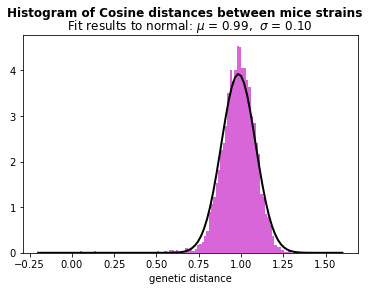

In [24]:
ax = plt.subplot()
plt.suptitle("Histogram of Cosine distances between mice strains", fontweight='bold')
strain_gen_dist_series = pd.Series(strain_genetic_dist.flatten())
hist_norm_fit(strain_gen_dist_series, ax, meth=norm, bins=100)
ax.set_xlabel("genetic distance")
plt.show()

<div class="alert alert-block alert-info">
    Once we mask the peak below 90, the distances genetic distance between strains looks like a gaussian distribution. Still need to investigate where does this ~90 pick comes from.
</div>

#### Weighted edges

In [25]:
def epsilon_similarity_graph(X: np.ndarray, metric='euclidean', sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    Dists = squareform(pdist(X,metric = "euclidean"))
    Dists = np.exp(-Dists**2/(2 * sigma**2))
    Dists[Dists <= epsilon] = 0
    np.fill_diagonal(Dists,0)
    return Dists

In [26]:
def compute_typical_distance(X,k = 5):
    """ Average distance of the k nearest neighbours for all points
    
    Args:
        X: numpy array of data points.
        k: number of neighbours
        
    Returns:
        mean_top: average distance of the k nearest neighbour
    
    """
    squ_norm = lambda x: x.T @ x
    mega_top = []
    for i,x1 in enumerate(X):
        top = []
        for j,x2 in enumerate(X):
            if (j != i):
                top.append(squ_norm(x1-x2))
        top = np.sort(top)[:k]
        mega_top.append(top)
    mean_top = np.mean(mega_top)
    return mean_top

In [27]:
def plot_distrib(adjacency):
    """ Plot the density of kerneled distances
    
    Args: 
        adjacency (np.array): adjacency matrix
        
    """
    non_zero = adjacency[np.nonzero(adjacency)]
    print("{:0.2f} % of the original data is kept".format(non_zero.size / adjacency.size * 100))
    plt.plot(np.sort(non_zero)[::-1])

# Exploration

## Gene graph

### Basic statistics

We create the weighted adjacency matrix here: the parameters to optimize (sigma, epsilon, metric etc) are in the cell right below

In [28]:
#adjacency = epsilon_similarity_graph(genotype_gene_expression_present_df.values, metric='cosine', sigma=70, epsilon=0.25)
weighted_adjacency = epsilon_similarity_graph(genotype_df.values, metric='cosine', sigma=70, epsilon=0.28)
#networkx graph
nx_weighted_graph = nx.from_numpy_array(weighted_adjacency)
#pygsp graph
pygsp_weighted_graph = graphs.Graph(weighted_adjacency,lap_type='normalized')

8.79 % of the original data is kept


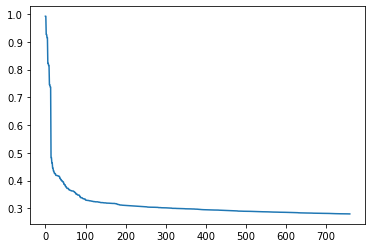

In [30]:
plot_distrib(weighted_adjacency)

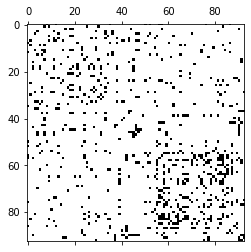

In [31]:
plt.spy(weighted_adjacency)
plt.show()

In [32]:
from tabulate import tabulate
def graph_basic_stats(G):
    nodes_number = G.number_of_nodes()
    edges_number = G.number_of_edges()

    g_degree = G.degree()
    sum_degree = sum(dict(g_degree).values())
    average_degree = sum_degree / nodes_number

    tab = [
        ["Number of nodes", nodes_number],
        ["Number of edges", edges_number],
        ["Graph density", round(nx.classes.function.density(G) * 100, 2)],
        ["Average degree", round(average_degree, 2)],
        ["Number of connected components", nx.number_connected_components(G)],
        ["Average clustering coefficient", round(nx.average_clustering(G), 2)],
        ["Diameter of the network (longest shortest path)", nx.diameter(G)]   
    ]
    print(tabulate(tab, tablefmt='fancy_grid'))
    
graph_basic_stats(nx_weighted_graph)

╒═════════════════════════════════════════════════╤════════╕
│ Number of nodes                                 │  93    │
├─────────────────────────────────────────────────┼────────┤
│ Number of edges                                 │ 380    │
├─────────────────────────────────────────────────┼────────┤
│ Graph density                                   │   8.88 │
├─────────────────────────────────────────────────┼────────┤
│ Average degree                                  │   8.17 │
├─────────────────────────────────────────────────┼────────┤
│ Number of connected components                  │   1    │
├─────────────────────────────────────────────────┼────────┤
│ Average clustering coefficient                  │   0.25 │
├─────────────────────────────────────────────────┼────────┤
│ Diameter of the network (longest shortest path) │   6    │
╘═════════════════════════════════════════════════╧════════╛


### Degree distribution

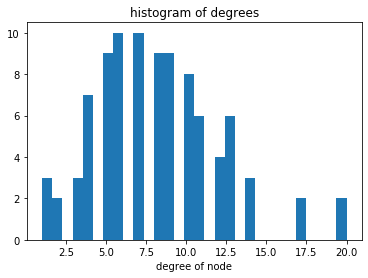

In [34]:
def plot_hist(G, bins=30):
    d = G.degree()
    plt.hist(list(dict(d).values()), bins=30)
    plt.xlabel('degree of node')
    plt.title('histogram of degrees')
    plt.show()
    
plot_hist(nx_weighted_graph)

### Spectral analysis 

#### Eigenvalues & Eigenvectors

In [35]:
pygsp_weighted_graph.compute_fourier_basis()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0e0fed240>)

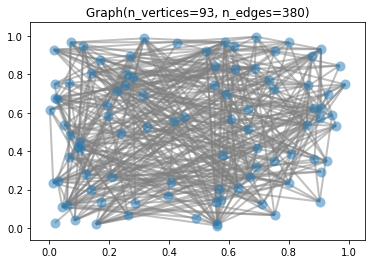

In [233]:
pygsp_weighted_graph.set_coordinates('random2D')
pygsp_weighted_graph.plot()

In [37]:
# Laplacian
pygsp_weighted_graph.compute_laplacian(lap_type= 'normalized')
laplacian_matrix = pygsp_weighted_graph.L
lamb_norm = pygsp_weighted_graph.e
#lamb_norm = nx.normalized_laplacian_spectrum(nx_weighted_graph)

Text(0.5, 1.0, 'Eigenvalues $L_{norm}$')

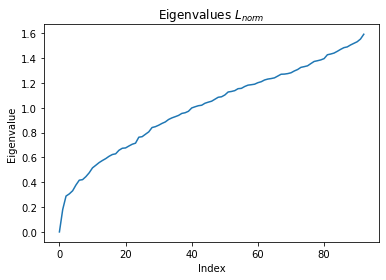

In [38]:
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

# Exploitation

### Labels (hait coat color)

Accuracy: 0.5114331085247392


(<Figure size 1440x432 with 6 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0e03feef0>)

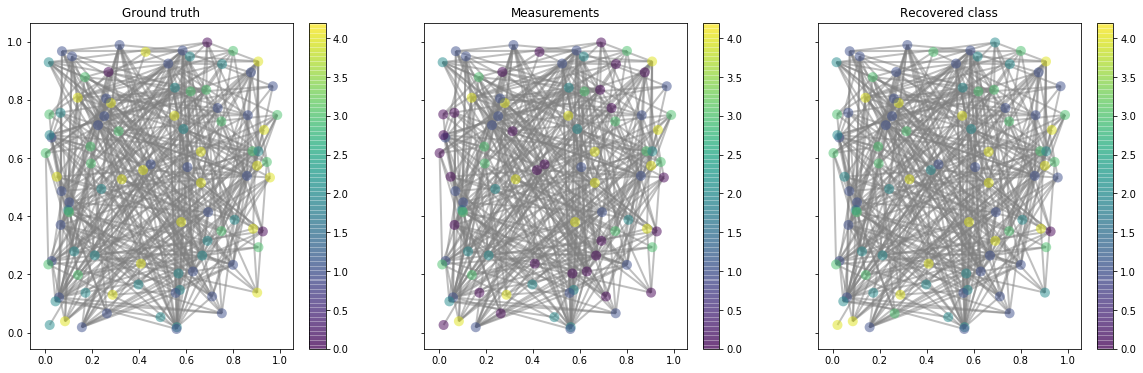

In [241]:
y_true = phenotype_df.loc['X62'][genotype_df.index].fillna(0)
#rs = np.random.RandomState(14)
NUM_REPET = 100
acc = 0
for i in range(NUM_REPET):
    rs = np.random.RandomState()
    mask = rs.uniform(0,1,pygsp_weighted_graph.N) > 0.2
    labels_true = y_true[~mask]
    y_sparse = y_true.copy()
    y_sparse[~mask] = np.nan

    recovery = learning.classification_tikhonov(pygsp_weighted_graph,y_sparse,mask,tau=0)
    #we get rid of the 0 value: we don't accept no label
    
    #recovery[:,0] = -1
    prediction = np.argmax(recovery, axis=1)

    labels_pred = prediction[~mask]
    acc += accuracy_score(labels_true,labels_pred)

print('Accuracy:',acc/NUM_REPET)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
#ground truth
pygsp_weighted_graph.plot_signal(y_true, ax=ax[0], title='Ground truth')
#measurements
pygsp_weighted_graph.plot_signal(y_sparse, ax=ax[1], title='Measurements')
#recover
pygsp_weighted_graph.plot_signal(prediction, ax=ax[2], title='Recovered class')

### Continuous variable

As we can see, there are more than 10 continuous phenotype who have

In [204]:
phenotype_df['nan_count'] = phenotype_df.isnull().sum(axis = 1)
top_continuous = phenotype_df.join(phenotype_id_aligner.set_index('PhenoID')[['quantitative_trait']],how = 'inner')
top_continuous = top_continuous[top_continuous.quantitative_trait == 'Yes'].sort_values('nan_count').head(5)

In [211]:
print('The best continuous variable are : {}'.format(' '.join(top_continuous.index.values)))

The best continuous variable are : X3820 X2397 X1002 X328 X218


In [219]:
ycont_true = phenotype_df.loc['X3820'][genotype_df.index]
ycont_true.fillna(ycont_true.mean(),inplace = True)


MSE or MAE: 0.7604722616897861


(<Figure size 1440x432 with 6 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0de6ae438>)

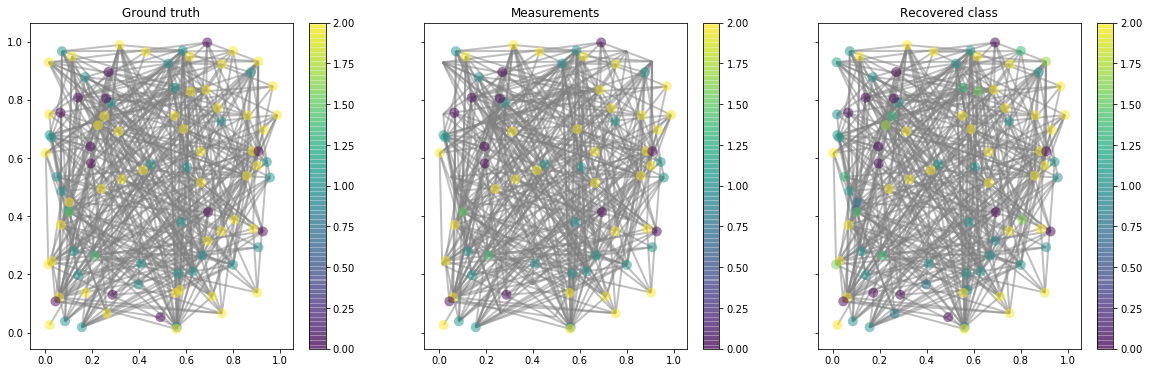

In [252]:
#CONTINUOUS CASE
NUM_REPET = 50
metric = 0
for i in range(NUM_REPET):
    mask = np.random.RandomState().uniform(0,1,pygsp_weighted_graph.N) > 0.2
    vals_true = ycont_true[~mask]
    ycont_sparse = ycont_true.copy()
    ycont_sparse[~mask] = np.nan

    recovery = learning.regression_tikhonov(pygsp_weighted_graph,ycont_sparse,mask,tau=0)
    #we get rid of the 0 value: we don't accept no label

    vals_pred = recovery[~mask]
    
    metric += mean_squared_error(vals_true,vals_pred)
    
metric /= NUM_REPET
print('MSE or MAE:',metric)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
limits = [ycont_true.min(),ycont_true.max()]

#ground truth
pygsp_weighted_graph.plot(ycont_true, ax=ax[0],limits = limits, title='Ground truth')
#measurements
pygsp_weighted_graph.plot_signal(ycont_sparse, ax=ax[1],limits = limits, title='Measurements')
#recover
pygsp_weighted_graph.plot_signal(recovery, ax=ax[2],limits = limits, title='Recovered class')